In [1]:
from data_loader import create_ted_datasets, get_ted_tokenizer, create_ted_datasets_raw
import numpy as np
import matplotlib.pyplot as plt

2023-06-29 04:33:21.716864: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
train_ted_ds, val_ted_ds = create_ted_datasets()
train_samples_raw,val_samples_raw = create_ted_datasets_raw()

In [3]:
train_samples_raw,len(train_samples_raw),len(val_samples_raw)

(<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>,
 51785,
 1193)

In [4]:
en_tokenizer, pt_tokenizer = get_ted_tokenizer()

lengths = []
for pt_example, en_example in train_samples_raw.batch(1024):
    pt_tokens = pt_tokenizer.tokenize(pt_example)
    lengths.append(pt_tokens.row_lengths())
    
    en_tokens = en_tokenizer.tokenize(en_example)
    lengths.append(en_tokens.row_lengths())
    print('.', end='', flush=True)

2023-06-29 04:33:40.603020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-06-29 04:33:40.603327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]


...................................................

In [5]:
all_lengths = np.concatenate(lengths)
all_lengths,len(all_lengths)

(array([25, 10, 12, ..., 49, 16, 18]), 103570)

Text(0.5, 1.0, 'Maximum token per example 320')

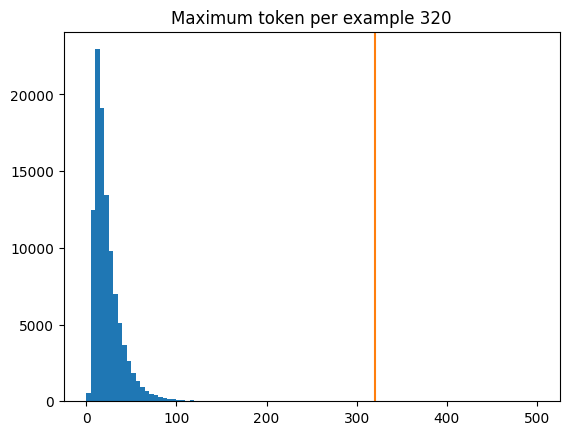

In [6]:
plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum token per example {max_length}')

## The embedding and position encoding layer

depth
(2048, 512)


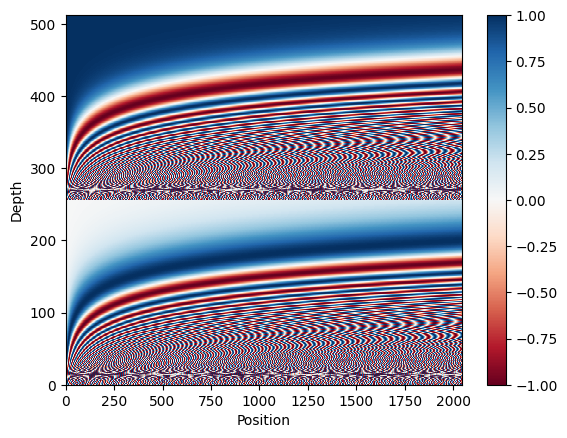

In [7]:
from model.positional_embedding import positional_encoding

pos_encoding = positional_encoding(length=2048, depth=512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()


(0.0, 1.0)

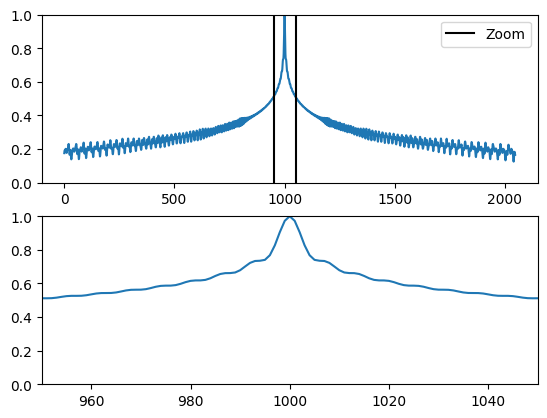

In [8]:
import tensorflow as tf

pos_encoding/= tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
        [0,1,float('nan'), 0, 1],
        color='k',
        label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])

In [9]:
for (pt, en), en_labels in train_ted_ds.take(1):
    break

print(pt_tokenizer.detokenize(pt))
print(en_tokenizer.detokenize(en))
print(pt.shape)
print(en.shape)
print(en_labels.shape)

2023-06-29 04:34:13.735798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2023-06-29 04:34:13.736254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_34' with dtype resource
	 [[{{node Placeholder/_34}}]]
2023-06-29 04:34:14.672582: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to 

tf.Tensor(
[b'que tal se essas plantas produzam mais sementes , possibilitando alimentar a tripulacao toda a partir dos poucos pacotes de sementes , durante toda a viagem ?'
 b'eu tinha 18 anos .'
 b'foi uma boa opcao , mas nao vamos examina - la mais .'
 b'temos que manter os nossos parques espantosos .'
 b'agora , enquanto mae , o que e que eu quero acima de tudo para os meus filhos ?'
 b'tenho os nos dos dedos brancos , de me agarrar a porta , estao a ver ?'
 b'o meu trabalho vai do micronivel ao macronivel , desenterrando historias escondidas .'
 b"` ` como testaremos a hipotese ` ` ' ' eu sou o meu conectoma ' ' ' ' ? ' '"
 b'vao para ver a mona lisa .'
 b'nao teriamos de escrever uma longa lista com tudo aquilo que nos e importante , ou ainda pior , enuncia - la numa linguagem de computador como c + + ou python , o que seria uma tarefa sem esperanca .'
 b"` ` ` ` ' ' ubuntu ' ' ' ' leva - nos a abrir o nosso coracao e a partilhar . o que solly me ensinou naquele dia foi a essenci

In [10]:
from model.positional_embedding import PositionalEmbedding

embed_pt = PositionalEmbedding(vocab_size=pt_tokenizer.get_vocab_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=en_tokenizer.get_vocab_size(), d_model=512)

pt_embed = embed_pt(pt)
en_embed = embed_en(en)

pt_embed,en_embed

depth
depth


(<tf.Tensor: shape=(64, 65, 512), dtype=float32, numpy=
 array([[[ 1.1029817 ,  0.7548464 ,  0.1384491 , ...,  1.5943744 ,
           1.20538   ,  1.4865541 ],
         [ 1.9469548 ,  1.4930639 ,  1.512787  , ...,  1.9944744 ,
           0.29828262,  1.8257465 ],
         [ 0.6762926 ,  1.7104299 ,  0.2365064 , ...,  1.724118  ,
           1.4356506 ,  0.07343966],
         ...,
         [ 0.15385157, -0.7369376 ,  0.35195208, ...,  1.1685233 ,
           0.66234905,  0.6731752 ],
         [ 1.060388  , -1.5020219 ,  0.31491214, ...,  1.1685226 ,
           0.66234833,  0.6731745 ],
         [ 1.8130584 , -1.506701  , -0.42624724, ...,  1.1685218 ,
           0.66234756,  0.6731739 ]],
 
        [[ 1.1029817 ,  0.7548464 ,  0.1384491 , ...,  1.5943744 ,
           1.20538   ,  1.4865541 ],
         [ 1.5538442 ,  0.58712405, -0.09815842, ...,  0.5681819 ,
           0.78167343,  1.3227413 ],
         [ 1.3672731 ,  0.5133027 ,  0.66917074, ...,  0.08830452,
           0.55552864,  1.44

In [11]:
en_embed._keras_mask

<tf.Tensor: shape=(64, 60), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

## Cross Attention

In [12]:
from model.attention import CrossAttention

sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(pt_embed.shape)
print(en_embed.shape)
after_cross_attn = sample_ca(en_embed,pt_embed)
print(after_cross_attn.shape)

(64, 65, 512)
(64, 60, 512)


2023-06-29 04:34:26.145444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


(64, 60, 512)


2023-06-29 04:34:26.497545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


## Global Attention

In [13]:
from model.attention import GlobalSelfAttention

global_self_attn = GlobalSelfAttention(num_heads=2,key_dim=512)

print(pt_embed.shape)
global_self_attn_output = global_self_attn(pt_embed)
print(global_self_attn_output.shape)

(64, 65, 512)
(64, 65, 512)


## Casual Attention

In [14]:
from model.attention import CasualSelfAttention

casual_attn = CasualSelfAttention(num_heads=2, key_dim=512)
print(en_embed.shape)
casual_attn_output = casual_attn(en_embed)
print(casual_attn_output.shape)

(64, 60, 512)
(64, 60, 512)


## Feed Forward

In [15]:
from model.feed_forward import FeedForward

sample_ffn = FeedForward(d_model=512,
                        dff=2048)

print(en_embed.shape)
sample_ffn_output = sample_ffn(en_embed)
print(sample_ffn_output.shape)

(64, 60, 512)
(64, 60, 512)


## Encoder Layer

In [16]:
from model.encoder import EncoderLayer

sample_encoder_layer = EncoderLayer(d_model=512, 
                                    num_heads=8, 
                                    dff=2048, 
                                    dropout_rate=0.1)
print(f'input is portugues language embedding of shape {pt_embed.shape}')
sample_encoder_layer_output = sample_encoder_layer(pt_embed)
print(f'output of encoder layer is of shape {sample_encoder_layer_output.shape}')

input is portugues language embedding of shape (64, 65, 512)
output of encoder layer is of shape (64, 65, 512)


## Encoder Block

In [17]:
from model.encoder import EncoderBlock

sample_encoder = EncoderBlock(num_layers=4, 
                              d_model=512, 
                              num_heads=8, 
                              dff=2048, 
                              vocab_size=8500, 
                              dropout_rate=0.1)
sample_encoder_output = sample_encoder(pt, training=False)
print(f'input to encoder block is portugues batch of shape {pt.shape}')
print(f'output of encoder block is {sample_encoder_output.shape}')

depth
input to encoder block is portugues batch of shape (64, 65)
output of encoder block is (64, 65, 512)


## Decoder Layer

In [18]:
from model.decoder import DecoderLayer

sample_decoder_layer = DecoderLayer(d_model=512, 
                                    num_heads=8, 
                                    dff=2048, 
                                    dropout_rate=0.1)
sample_decoder_layer_output = sample_decoder_layer(x=en_embed,
                                                   context=pt_embed)
print(f'input shape of english embedding {en_embed.shape}')
print(f'context shape of portugues embedding {pt_embed.shape}')
print(f'output shape of decoder layer {sample_decoder_layer_output.shape}')

input shape of english embedding (64, 60, 512)
context shape of portugues embedding (64, 65, 512)
output shape of decoder layer (64, 60, 512)


## Decoder Block

In [19]:
from model.decoder import DecoderBlock

sample_decoder = DecoderBlock(num_layers=4, 
                              d_model=512, 
                              num_heads=8, 
                              dff=2048, 
                              vocab_size=8000, 
                              dropout_rate=0.1)
sample_decoder_output = sample_decoder(x=en,
                                      context=pt_embed)
print(f'input shape of english shape {en.shape}')
print(f'context shape of portugues embedding {pt_embed.shape}')
print(f'output shape of decoder layer {sample_decoder_output.shape}')

depth
input shape of english shape (64, 60)
context shape of portugues embedding (64, 65, 512)
output shape of decoder layer (64, 60, 512)


In [20]:
sample_decoder.last_attn_scores.shape

TensorShape([64, 8, 60, 65])

## Transformer

In [21]:
from model.transformer import Transformer

transformer = Transformer(num_layers=4, 
                          d_model=512, 
                          num_heads=8, 
                          dff=2048, 
                          src_vocab_size=pt_tokenizer.get_vocab_size(), 
                          target_vocab_size=en_tokenizer.get_vocab_size(), 
                          dropout_rate=0.1)
transformer_output = transformer((pt,en))
print(f'input shape of english shape {en.shape}')
print(f'context shape of portugues  {pt.shape}')
print(f'output shape of transformer {transformer_output.shape}')

depth
depth
input shape of english shape (64, 60)
context shape of portugues  (64, 65)
output shape of transformer (64, 60, 7010)


In [22]:
attn_scores = transformer.decoder.decoder_layer[-1].last_attn_scores
print(attn_scores.shape)

(8, 8, 48, 45)


In [22]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_block_1 (EncoderBlo  multiple                 45988352  
 ck)                                                             
                                                                 
 decoder_block_1 (DecoderBlo  multiple                 79211520  
 ck)                                                             
                                                                 
 dense_38 (Dense)            multiple                  3596130   
                                                                 
Total params: 128,796,002
Trainable params: 128,796,002
Non-trainable params: 0
_________________________________________________________________


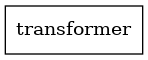

In [23]:
from tensorflow.keras.utils import plot_model

plot_model(transformer, show_shapes=True)

## Training

In [24]:
from train import TransformerTraining

training = TransformerTraining()
training.compile()

depth
depth


In [25]:
training.fit(train_ted_ds, val_ted_ds)

2023-06-29 04:35:11.865512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2023-06-29 04:35:11.866073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_33' with dtype string
	 [[{{node Placeholder/_33}}]]


Epoch 1/3


2023-06-29 04:35:33.339948: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 122.00MiB (rounded to 127926272)requested by op transformer_1/encoder_block_2/encoder_layer_9/global_self_attention_10/multi_head_attention_30/key/einsum/Einsum
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-06-29 04:35:33.340082: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-06-29 04:35:33.340103: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 360, Chunks in use: 360. 90.0KiB allocated for chunks. 90.0KiB in use in bin. 903B client-requested in use in bin.
2023-06-29 04:35:33.340112: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 

2023-06-29 04:35:43.355506: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 122.00MiB (rounded to 127926272)requested by op transformer_1/encoder_block_2/encoder_layer_9/global_self_attention_10/multi_head_attention_30/query/einsum/Einsum
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-06-29 04:35:43.355607: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-06-29 04:35:43.355621: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 360, Chunks in use: 360. 90.0KiB allocated for chunks. 90.0KiB in use in bin. 903B client-requested in use in bin.
2023-06-29 04:35:43.355629: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin

2023-06-29 04:35:53.368806: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 122.00MiB (rounded to 127926272)requested by op transformer_1/encoder_block_2/encoder_layer_9/global_self_attention_10/multi_head_attention_30/value/einsum/Einsum
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-06-29 04:35:53.368907: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-06-29 04:35:53.368917: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 360, Chunks in use: 360. 90.0KiB allocated for chunks. 90.0KiB in use in bin. 903B client-requested in use in bin.
2023-06-29 04:35:53.368923: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin

ResourceExhaustedError: Graph execution error:

Detected at node 'transformer_1/encoder_block_2/encoder_layer_9/global_self_attention_10/multi_head_attention_30/key/einsum/Einsum' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_13/1555153759.py", line 1, in <module>
      training.fit(train_ted_ds, val_ted_ds)
    File "/tf/2023/attention-is-all-you-need/train.py", line 66, in fit
      self.training_history = self.transformer.fit(train_batches,
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tf/2023/attention-is-all-you-need/model/transformer.py", line 26, in call
      context = self.encoder(context)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tf/2023/attention-is-all-you-need/model/encoder.py", line 44, in call
      for i in range(self.num_layers):
    File "/tf/2023/attention-is-all-you-need/model/encoder.py", line 45, in call
      x = self.encoder[i](x)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tf/2023/attention-is-all-you-need/model/encoder.py", line 18, in call
      x = self.self_attention(x)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/tf/2023/attention-is-all-you-need/model/attention.py", line 30, in call
      attn_output = self.multi_head_attention(query=x,
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/attention/multi_head_attention.py", line 593, in call
      key = self._key_dense(key)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/layers/core/einsum_dense.py", line 207, in call
      ret = tf.einsum(self.equation, inputs, self.kernel)
Node: 'transformer_1/encoder_block_2/encoder_layer_9/global_self_attention_10/multi_head_attention_30/key/einsum/Einsum'
OOM when allocating tensor with shape[7808,4096] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node transformer_1/encoder_block_2/encoder_layer_9/global_self_attention_10/multi_head_attention_30/key/einsum/Einsum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_39919]